In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import mne
import pathlib
import pytorch_lightning as pl
import torch
import torcheeg
import xgboost
import wandb
import autoreject
from tqdm.notebook import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../src')
# from preprocessing import preprocess_data
from transforms import _compose, _randomcrop, totensor, \
channelwide_norm, channelwise_norm, _clamp, toimshape, \
_labelcenter, _labelnorm, _labelbin
from functools import partial
from data import BrainAgeDataset

In [3]:
# from pytorch_lightning.callbacks.early_stopping import EarlyStopping
# from pytorch_lightning.tuner import Tuner

### Interface with data

In [4]:
data_dir = pathlib.Path("/data0/practical-sose23/brain-age/data/lemon/LEMON_RAW")
assert data_dir.is_dir()

In [5]:
eeg_files_all = list(data_dir.rglob("*.vhdr"))
len(eeg_files_all)

215

In [6]:
len(list(data_dir.rglob("*.vhdr"))), \
len(list(data_dir.rglob("*.vmrk"))), \
len(list(data_dir.rglob("*.eeg")))

(215, 215, 215)

In [7]:
def get_midpoint(age_range):
    low, high = age_range.split("-")
    return (int(high)+int(low))/2 

In [8]:
f_namemap = list(data_dir.parent.rglob("*name*.csv"))[0]
df_namemap = pd.read_csv(f_namemap)
namemap = {old:new for old, new in zip(df_namemap["Initial_ID"], df_namemap["INDI_ID"])}

In [9]:
f_subj = list(data_dir.parent.rglob("*Age*.csv"))[0]
df_subj = pd.read_csv(f_subj)
df_subj["Subject ID"] = df_subj['Unnamed: 0']
df_subj, df_subj["Age"].apply(get_midpoint)

(     Unnamed: 0  Gender_ 1=female_2=male    Age Handedness  Education  \
 0    sub-032311                        2  20-25      right  Gymnasium   
 1    sub-032309                        2  20-25      right  Gymnasium   
 2    sub-032382                        2  25-30      right  Gymnasium   
 3    sub-032302                        1  20-25      right  Gymnasium   
 4    sub-032315                        2  20-25      right  Gymnasium   
 ..          ...                      ...    ...        ...        ...   
 223  sub-032304                        2  25-30      right  Gymnasium   
 224  sub-032439                        2  20-25       left  Gymnasium   
 225  sub-032440                        2  25-30       left  Gymnasium   
 226  sub-032441                        2  25-30      right  Gymnasium   
 227  sub-032525                        2  20-25      right  Gymnasium   
 
          DRUG  DRUG_0=negative_1=Positive Unnamed: 7            Smoking  \
 0    negative                    

### Analyze the subject data

In [10]:
def get_midpoint(age_range):
    low, high = age_range.split("-")
    return (int(high)+int(low))/2 

def get_subj_id(eeg_file: pathlib.Path):
    return eeg_file.stem

def get_age(df_subj, eeg_file: pathlib.Path):
    subj_id = get_subj_id(eeg_file)
    return get_midpoint(df_subj[df_subj["Subject ID"] == namemap[subj_id]]["Age"].values[0])

#### Check the metadata and set channel types

In [11]:
example_raw = mne.io.read_raw_brainvision(eeg_files_all[0])
# example_raw

Extracting parameters from /data0/practical-sose23/brain-age/data/lemon/LEMON_RAW/sub-010270/RSEEG/sub-010270.vhdr...
Setting channel info structure...


In [12]:
channel_to_channel_type = {ch_name:"eeg" for ch_name in example_raw.ch_names}
channel_to_channel_type.update({"VEOG":"misc"})
# eeg_chs = [ch for ch in example_raw.ch_names if not (ch=="RE" or ch=="LE")]
example_raw.set_channel_types(channel_to_channel_type)


/tmp/ipykernel_5432/322076733.py:4: RuntimeWarning: The unit for channel(s) VEOG has changed from V to NA.
  example_raw.set_channel_types(channel_to_channel_type)


<RawBrainVision | sub-010270.eeg, 62 x 2550900 (1020.4 s), ~67 kB, data not loaded>

In [13]:
montage = mne.channels.make_standard_montage("standard_1020")
example_raw = example_raw.set_montage(montage)

### Preprocess data

In [14]:
import pandas as pd
import pathlib

class LemonMetaDataset:
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.namemap = self.map_name()
        self.df_subj = self.load_df_subj()

    def map_name(self):
        f_namemap = list(self.data_dir.parent.rglob("*name*.csv"))[0]
        df_namemap = pd.read_csv(f_namemap)
        namemap = {old: new for old, new in zip(df_namemap["Initial_ID"], df_namemap["INDI_ID"])}
        return namemap
    
    def load_df_subj(self):
        f_subj = list(data_dir.parent.rglob("*Age*.csv"))[0]
        df_subj = pd.read_csv(f_subj)
        df_subj["Subject ID"] = df_subj['Unnamed: 0']
        df_subj["Age"].apply(get_midpoint)
        return df_subj
        
    @staticmethod
    def get_midpoint(age_range):
        low, high = age_range.split("-")
        return (int(high) + int(low)) / 2

    @staticmethod
    def get_subject_id(eeg_file):
        return eeg_file.stem

    def get_age(self, df_subj, subj_id):
        return self.get_midpoint(df_subj[df_subj["Subject ID"] == self.namemap[subj_id]]["Age"].values[0])

    def extract_age(self, eeg_file):
        subj_id = self.get_subject_id(eeg_file)
        age = self.get_age(self.df_subj, subj_id)
        return age

In [15]:
def raw_to_np(raw):
    return raw.get_data()

In [41]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import pickle

class LemonEEGDataset(Dataset):
    def __init__(self, filepaths, metadata, transforms=None, target_transforms=None):
        self.filepaths = filepaths
        self.metadata = metadata
        self.transforms = transforms
        self.target_transforms = target_transforms
    
    def load_eeg_data(self, filepath):
        with open(filepath, "rb") as f:
            eeg_data = pickle.load(f)
        return eeg_data
        
    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        filepath = self.filepaths[idx]

        # Load EEG data from file
        eeg_data = self.load_eeg_data(filepath)

        # Apply transforms if provided
        if self.transforms:
            eeg_data = self.transforms(eeg_data)

        # Extract age using the provided extract_age function
        age = self.metadata.extract_age(filepath)
        
        if self.target_transforms:
            age = self.target_transforms(age)

        return eeg_data, age

In [18]:
import pickle
# Directory to save processed MNE objects
output_directory = (data_dir / ".." / "derivatives").resolve()
output_directory.mkdir(parents=True, exist_ok=True)

sfreq = 135  # int(example_raw.info["sfreq"])
l_freq = 0.5
h_freq = sfreq / (1 + 2)

epochs = []
ages = []
c = 0
for f in tqdm(eeg_files_all):
    sub_id = get_subj_id(f)
    age = get_age(df_subj, f)
    try:
        raw = mne.io.read_raw_brainvision(f, verbose=False, preload=True)
    except FileNotFoundError:
        continue
    break

    raw.set_channel_types(channel_to_channel_type)
    raw.set_montage(montage)

    raw = raw.filter(l_freq=l_freq, h_freq=h_freq, h_trans_bandwidth=5)
    raw = raw.resample(sfreq=sfreq)    

    # Get the original file extension
    file_extension = f.suffix
    output_filename = f"{sub_id}{file_extension}"
    output_path = output_directory / output_filename
    
    with open(output_path, "wb") as f:
            pickle.dump(raw, f)
    break
    epochs_subj = mne.make_fixed_length_epochs(raw, duration=10, preload=True)
    reject = autoreject.get_rejection_threshold(epochs_subj, decim=2)
    epochs_subj.drop_bad(reject=reject)
    epochs.append(epochs_subj.get_data())
    ages.append(len(epochs_subj)*[age])

  0%|          | 0/215 [00:00<?, ?it/s]

### Neural network baseline

In [19]:
from torcheeg.models import EEGNet

In [59]:
hparams_eegnet = {
    "learning_rate":1e-2,
    "batch_size":128,
    "chunk_size":int(sfreq*4),
    "dropout":0.0,
    "kernel_1": int(sfreq//2),
    "kernel_2": int(sfreq//8),
    "F1":16,
    "F2":32,
    "depth_multiplier":2
}

eegnet = EEGNet(chunk_size=hparams_eegnet["chunk_size"],
               num_electrodes=62,
               dropout=hparams_eegnet["dropout"],
               kernel_1=hparams_eegnet["kernel_1"],
               kernel_2=hparams_eegnet["kernel_2"],
               F1=hparams_eegnet["F1"],
               F2=hparams_eegnet["F2"],
               D=hparams_eegnet["depth_multiplier"],
               num_classes=1)

#### Configure transforms

In [60]:
mean_age = torch.tensor(round(df_subj["Age"].apply(get_midpoint).mean(), 3))

randomcrop = partial(_randomcrop, seq_len=hparams_eegnet["chunk_size"])
clamp = partial(_clamp, dev_val=10.0)
labelcenter = partial(_labelcenter, mean_age=mean_age)
labelbin = partial(_labelbin, y_lower=mean_age)
transforms = partial(_compose, transforms=[raw_to_np, totensor, randomcrop, channelwise_norm, clamp, toimshape])
target_transforms = partial(_compose, transforms=[labelcenter, totensor])

In [16]:
lemon_metadata = LemonMetaDataset(data_dir.parent / "derivatives")
eeg_files_preprocessed = list((data_dir.parent / "derivatives").rglob("*.vhdr"))
len(eeg_files_preprocessed)

211

#### Split data across subjects

In [61]:
import random
random.shuffle(eeg_files_preprocessed)
n_train = int(0.7*len(eeg_files_preprocessed))
n_val = int(0.15*len(eeg_files_preprocessed))
eeg_files_train = eeg_files_preprocessed[:n_train]
eeg_files_val = eeg_files_preprocessed[n_train:n_train+n_val]
eeg_files_test = eeg_files_preprocessed[n_train+n_val:]

dataset_train = LemonEEGDataset(eeg_files_train, lemon_metadata, transforms=transforms, target_transforms=target_transforms)
dataset_val = LemonEEGDataset(eeg_files_val, lemon_metadata, transforms=transforms, target_transforms=target_transforms)
dataset_test = LemonEEGDataset(eeg_files_test, lemon_metadata, transforms=transforms, target_transforms=target_transforms)

In [62]:
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=hparams_eegnet["batch_size"], num_workers=16, shuffle=True, drop_last=True)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=hparams_eegnet["batch_size"], num_workers=16, drop_last=True)

print(f"# training samples: {len(dataset_train)}")
print(f"# validation samples: {len(dataset_val)}")

# training samples: 147
# validation samples: 31


#### Visualize random data points 

tensor(-3.8739e-09) tensor(0.9973) tensor(3.8489)


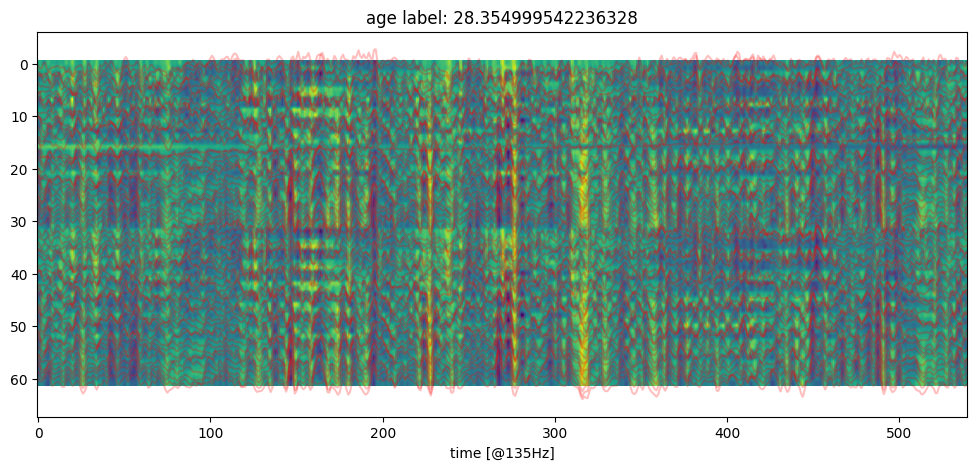

In [63]:
for eeg, age in dataloader_train.dataset:
    plt.figure(figsize=(12,5))
    print(eeg.mean(), eeg.std(), eeg.max())
    plt.title(f"age label: {str(age.item())}")
    plt.imshow(eeg[0], aspect="auto")
    
    plt.plot(eeg[0].T + torch.arange(eeg.shape[1]).unsqueeze(0), "r", alpha=0.25)
    plt.xlabel(f"time [@{sfreq}Hz]")

    plt.show()
    break



In [64]:
eeg.shape, hparams_eegnet["chunk_size"]

(torch.Size([1, 62, 540]), 540)

In [65]:
# len(np.concatenate(epochs)), len(np.concatenate(ages)), \
# len(np.concatenate(epochs_train)), len(np.concatenate(ages_train))

In [77]:
import lightning.pytorch as pl

In [78]:
class BrainAgeModel(pl.LightningModule):
        
    def __init__(self, model, hparams, loss_func, metric=None):
        super().__init__()
        self.model = model
        self.hparams.update(hparams)
        self.loss_func = loss_func
        self.metric = metric
        
    def forward(self, x):
        x = self.model(x)
        return x
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams["learning_rate"])
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        val_loss = self.loss_func(y_hat.squeeze(), y.squeeze())
        self.log("validation loss", val_loss, on_step=True, on_epoch=True, prog_bar=True)
        if self.metric:
            metric_val = self.metric["func"](y_hat.squeeze(), y.squeeze())
#             print(f"==================Val Acc: {metric_val} =======================")
#             print(y_hat.squeeze()[:2], y.squeeze()[:2])
            self.log("val_"+self.metric["name"], metric_val, on_step=True, on_epoch=True, prog_bar=True)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss_func(y_hat.squeeze(), y.squeeze())
        self.log("training loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        if self.metric:
            metric_val = self.metric["func"](y_hat.squeeze(), y.squeeze())
#             print(f"==================Train Acc: {metric_val} =======================")
#             print(y_hat.squeeze()[:2], y.squeeze()[:2])
            self.log("train_"+self.metric["name"], metric_val, on_step=True, on_epoch=True, prog_bar=True)

        return loss

#### Set-up metrics

In [79]:
def score_accuracy(y_hat, y):
    return (y==torch.argmax(y_hat, dim=-1)).float().mean()

def score_binary_accuracy(y_hat, y):
    y_hat = torch.sigmoid(y_hat)
    return (y==torch.round(y_hat)).float().mean()

def score_binary_accuracy_v2(y_hat, y):
    y_hat = torch.sigmoid(y_hat)
    return (y==torch.where(y_hat > 0.5, 1.0, 0.0)).float().mean()

def _score_r2(y_hat, y, y_var):
    return  1 - torch.nn.functional.mse_loss(y.squeeze(), y_hat.squeeze()) / y_var
    
score_r2 = partial(_score_r2, y_var=df_subj["Age"].apply(get_midpoint).var())

def compute_r2(model, val_dataloader):
    model.eval(), model.cpu()
    rss, tss = 0, 0
    for batch in val_dataloader:
        x, y = batch
        y_hat = model.forward(x)
        rss += torch.nn.functional.mse_loss(y.squeeze(), y_hat.squeeze())
        tss += y.var()
    return 1 - rss/tss

### Initialize model

In [80]:
model = BrainAgeModel(
    model=list(eegnet.modules())[0], 
    hparams=hparams_eegnet, 
    loss_func=torch.nn.functional.l1_loss,
    metric={"name":"r2", "func":score_r2}
)
print(model)

BrainAgeModel(
  (model): EEGNet(
    (block1): Sequential(
      (0): Conv2d(1, 16, kernel_size=(1, 67), stride=(1, 1), padding=(0, 33), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Conv2dWithConstraint(16, 32, kernel_size=(62, 1), stride=(1, 1), groups=16, bias=False)
      (3): BatchNorm2d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (4): ELU(alpha=1.0)
      (5): AvgPool2d(kernel_size=(1, 4), stride=4, padding=0)
      (6): Dropout(p=0.2, inplace=False)
    )
    (block2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), groups=32, bias=False)
      (1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (3): ELU(alpha=1.0)
      (4): AvgPool2d(kernel_size=(1, 8), stride=8, padding=0)
      (5): Dropout(p=0.2, inplace=False)
    )
    (

#### Test fwd pass

In [81]:
# example_out = model(dataloader_train.dataset[0][0].unsqueeze(0))
example_out = model(next(iter(dataloader_train))[0])
example_out.shape, example_out.min(), example_out.max()

/u/home/swth/brain-age/drafts/schwarz/transforms.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x).float()


(torch.Size([128, 1]),
 tensor(-0.6182, grad_fn=<MinBackward1>),
 tensor(0.5161, grad_fn=<MaxBackward1>))

#### Specify experiment name and train 

In [82]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

In [85]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
wandb.finish()

overfit_batches = 1
wandb.login()
logger = pl.loggers.WandbLogger(project="brain-age-ssl", name=f"Lemon EEGNet regression baseline on {overfit_batches} batches", 
                                save_dir="/data0/practical-sose23/brain-age", log_model=False)

early_stop_callback = EarlyStopping(monitor="training loss", min_delta=0.00, patience=25, verbose=False, mode="min")

trainer = pl.Trainer(
    callbacks=[early_stop_callback], 
    max_epochs=1000, 
    accelerator="gpu",
    precision="bf16",
    logger=logger)
# Tuner(trainer).lr_find(model, dataloader_train)

trainer.fit(model, dataloader_train, dataloader_val)
wandb.finish()

/u/home/swth/.conda/envs/my_brain_age_env/lib/python3.10/site-packages/lightning/fabric/connector.py:562: UserWarning: bf16 is supported for historical reasons but its usage is discouraged. Please set your precision to bf16-mixed instead!
  rank_zero_warn(
/u/home/swth/.conda/envs/my_brain_age_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /u/home/swth/.conda/envs/my_brain_age_env/lib/python ...
  rank_zero_warn(
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('me

Sanity Checking: 0it [00:00, ?it/s]

/u/home/swth/.conda/envs/my_brain_age_env/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:103: UserWarning: Total length of `DataLoader` across ranks is zero. Please make sure this was your intention.
  rank_zero_warn(
/u/home/swth/.conda/envs/my_brain_age_env/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/u/home/swth/brain-age/drafts/schwarz/transforms.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x).float()
/u/home/swth/brain-age/drafts/schwarz/transforms.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x).float()
/u/home/swth/brain-age/drafts/schwarz/transforms.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x).float()
/u/home/swth/brain-age/drafts/schwarz/transforms.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone

epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
train_r2_epoch,▃▂▆▁▆▄▃▅▆▃▄▇▇▅▇▆▄▆▆█▄█
trainer/global_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
training loss_epoch,▇█▅█▅▆▆▅▄▆▅▃▃▄▃▃▄▃▃▁▃▁
epoch,21
train_r2_epoch,0.13388
trainer/global_step,21
training loss_epoch,14.95899


In [81]:
!nvidia-smi

Thu Jun  1 18:27:30 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A40                      On | 00000000:01:00.0 Off |                    0 |
|  0%   42C    P0               77W / 300W|   4020MiB / 46068MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--